# Andrew Kim

# ADS 509-01-SU23: Applied Text Mining

# Assignment 5.1: Topic Modeling

# 6/12/2023

# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 

In [2]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation
from spacy.lang.en.stop_words import STOP_WORDS as stopwords
from collections import Counter, defaultdict

import en_core_web_sm
nlp = en_core_web_sm.load()
nlp = spacy.load('en_core_web_sm')

C:\Users\andre\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
# add any additional libraries you need here
import nltk
nltk.download('brown')
import warnings
warnings.filterwarnings('ignore')

C:\Users\andre\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[nltk_data] Downloading package brown to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package brown is already up-to-date!


In [4]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [6]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [7]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='category'>

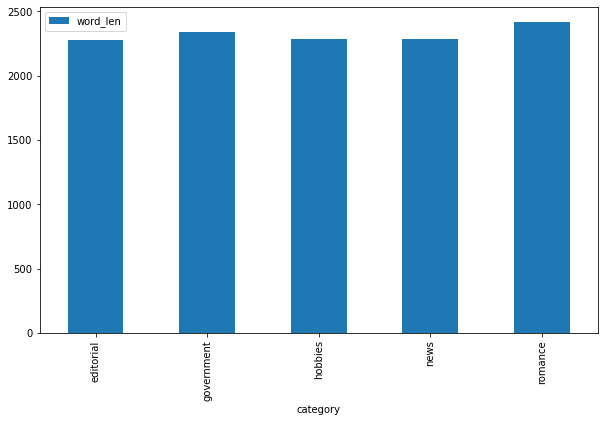

In [8]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [9]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

(166, 4941)

In [10]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: __The data frame 'count_text_vectors' holds a collection of the text/word counts from each document in Brown corpus. Essentially, each document features a vector that contains the count of the texts/words within each document.__

__The data frame 'tfidf_text_vectors' holds a collection of the text/word counts that matches TF-IDF (Term Frequency - Inverse Document Frequency) from the documents. In this instance, each document features a vector that contains the words that appear relevant towards each document or within a series or corpus. This adds a weighting factor towards a modeling process when identifying words that appear most relevant from each document.__ 

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [11]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [12]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 

In [13]:
# Your code here
def compare(orig_df, W_text_matrix):
    #Generate a list of Brown categories by topic
    #Analyze document by document
    #Code provided by professor from Slack channel
    category_by_topic = defaultdict(list) 
    for idx, row in enumerate(W_text_matrix): 
        topic = np.where(row == np.amax(row))[0] 
        category = orig_df['category'].iloc[idx] 
        category_by_topic[topic[0]].append(category)

    article_count = orig_df['category'].value_counts().to_dict()    
    
    unique_categories = sorted(set(category for categories in category_by_topic.values()
                                   for category in categories))

    for category in unique_categories:
        for key in sorted(category_by_topic): 
            category_counts = Counter(category_by_topic[key]) 
            if category in category_counts:  
                print(
                    f'For Category {category} we have '
                    f'{category_counts[category]} Articles in Topic {key} '
                    f'(vs. {category} Actual of {article_count[category]}).')
                
compare(df, W_text_matrix)

For Category editorial we have 20 Articles in Topic 0 (vs. editorial Actual of 27).
For Category editorial we have 4 Articles in Topic 1 (vs. editorial Actual of 27).
For Category editorial we have 2 Articles in Topic 2 (vs. editorial Actual of 27).
For Category editorial we have 1 Articles in Topic 4 (vs. editorial Actual of 27).
For Category government we have 4 Articles in Topic 0 (vs. government Actual of 30).
For Category government we have 26 Articles in Topic 2 (vs. government Actual of 30).
For Category hobbies we have 8 Articles in Topic 1 (vs. hobbies Actual of 36).
For Category hobbies we have 26 Articles in Topic 2 (vs. hobbies Actual of 36).
For Category hobbies we have 1 Articles in Topic 3 (vs. hobbies Actual of 36).
For Category hobbies we have 1 Articles in Topic 4 (vs. hobbies Actual of 36).
For Category news we have 8 Articles in Topic 0 (vs. news Actual of 44).
For Category news we have 11 Articles in Topic 2 (vs. news Actual of 44).
For Category news we have 17 Art

Q: How does your five-topic NMF model compare to the original Brown categories? 

A: __The five-topic NMF model generated a stacked categorical list of articles pertaining towards each "Topic" number (i.e.: 0, 1, 2, 3, 4) that was bunched, but specified towards each "Category" type (i.e.: editorial government, hobbies, news, and romance) with the number of articles towards each "Topic" number.__

__In general, the NMF model generated results that were mixed with a diversity of the number of articles towards "Topic" number and "Category" type. Upon analysis of the results, the Categories "editorial", "hobbies", and "news" were highly various across four "Topic" numbers, with the "news" category receiving the most number of various articles while the "romance" category received less variation after being various towards Topic 1 at 29 articles.__

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [14]:
# Your code here
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_text_matrix = lsa_text_model.components_

compare(df, W_lsa_text_matrix)

For Category editorial we have 27 Articles in Topic 0 (vs. editorial Actual of 27).
For Category government we have 30 Articles in Topic 0 (vs. government Actual of 30).
For Category hobbies we have 36 Articles in Topic 0 (vs. hobbies Actual of 36).
For Category news we have 34 Articles in Topic 0 (vs. news Actual of 44).
For Category news we have 3 Articles in Topic 3 (vs. news Actual of 44).
For Category news we have 7 Articles in Topic 4 (vs. news Actual of 44).
For Category romance we have 21 Articles in Topic 0 (vs. romance Actual of 29).
For Category romance we have 8 Articles in Topic 1 (vs. romance Actual of 29).


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: __The results generated by the five-topic LSA model were more consistent and clean compared to the NMF model in that the results appeared to focus more towards a specific Topic number (in this case, Topic 0) towards each Category type. Like the NMF model, the news category featured more various articles, total of 44, across three topics. On the contrary, the romance category varied more towards the number of articles across two topics.__

In [15]:
# call display_topics on your model
display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: __Each topic number includes a list of the top-five words that appeared important or relevant towards a respective article. The word list featured under each topic appears to be arranged in a descending order and is based on the importance of each word towards an article number/type, with the top word of the list being labeled as highly important and relevant to what a respective topic is about.__

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [16]:
# Fit your LDA model here
lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_text_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_text_matrix = lda_text_model.components_

In [17]:
compare(df, W_lda_text_matrix)

For Category editorial we have 3 Articles in Topic 0 (vs. editorial Actual of 27).
For Category editorial we have 1 Articles in Topic 1 (vs. editorial Actual of 27).
For Category editorial we have 21 Articles in Topic 2 (vs. editorial Actual of 27).
For Category editorial we have 2 Articles in Topic 3 (vs. editorial Actual of 27).
For Category government we have 1 Articles in Topic 0 (vs. government Actual of 30).
For Category government we have 12 Articles in Topic 1 (vs. government Actual of 30).
For Category government we have 3 Articles in Topic 2 (vs. government Actual of 30).
For Category government we have 4 Articles in Topic 3 (vs. government Actual of 30).
For Category government we have 10 Articles in Topic 4 (vs. government Actual of 30).
For Category hobbies we have 11 Articles in Topic 0 (vs. hobbies Actual of 36).
For Category hobbies we have 9 Articles in Topic 1 (vs. hobbies Actual of 36).
For Category hobbies we have 2 Articles in Topic 2 (vs. hobbies Actual of 36).
Fo

In [18]:
# Call `display_topics` on your fitted model here
display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: __An inference to draw from the LDA model's displayed topics is how the weighed decimal values of each term under each topic appears to be more smoothed out evenly and balanced.__

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: __In comparison to the original Brown categories, the five-topic LDA model generates a result where the Category types are more expansive and diverse within the number of articles correlating towards each Topic number. On this occassion, the Category "hobbies" expands across all five Topic numbers compared to "editorial", "government", and "news" while the Category "romance" is only pertained and directed to a single topic number, in this instance Topic 4.__

In [19]:
import pyLDAavis.lda_model
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, 
                                         count_text_vectorizer, sort_topics=False)

In [20]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: __The visualization above generates a variance report of variables that are either uncorrelated or similar towards all topics from the original Brown data. While Topics 2, 3, and 4 touch or coincide, which indicates that they correlate in terms of significant words within each topic, the most relative terms are inside Topic 3 based on the bubble's size being the biggest. To coincide with the list of the top-30 salient terms, each bubble includes the probability distribution of the frequency of terms from the list.__